# 2D time-independent heat equation

From the tutorial
+ https://docs.sciml.ai/MethodOfLines/stable/tutorials/heatss/
+ https://docs.sciml.ai/MethodOfLines/stable/tutorials/heat/

Using `MethodOfLines.jl` (https://github.com/SciML/MethodOfLines.jl/) to symbolically define the PDE system and use the [finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) (FDM) to solve the following PDE:

$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}
$$

In [1]:
using ModelingToolkit
using MethodOfLines
using DomainSets
using OrdinaryDiffEq
using NonlinearSolve
using Plots

Setup variables and differential operators

In [2]:
@independent_variables x y
@variables u(..)

Dxx = Differential(x)^2
Dyy = Differential(y)^2

Differential(y) ∘ Differential(y)

PDE equation

In [3]:
eq = Dxx(u(x, y)) + Dyy(u(x, y)) ~ 0

Differential(y)(Differential(y)(u(x, y))) + Differential(x)(Differential(x)(u(x, y))) ~ 0

Boundary conditions

In [4]:
bcs = [u(0, y) ~ x * y,
       u(1, y) ~ x * y,
       u(x, 0) ~ x * y,
       u(x, 1) ~ x * y
]

4-element Vector{Symbolics.Equation}:
 u(0, y) ~ x*y
 u(1, y) ~ x*y
 u(x, 0) ~ x*y
 u(x, 1) ~ x*y

Space and time domains

In [5]:
domains = [ x ∈ Interval(0.0, 1.0), y ∈ Interval(0.0, 1.0)]

2-element Vector{Symbolics.VarDomainPairing}:
 Symbolics.VarDomainPairing(x, 0.0 .. 1.0)
 Symbolics.VarDomainPairing(y, 0.0 .. 1.0)

PDE system

In [6]:
@named pdesys = PDESystem(eq, bcs, domains, [x, y], [u(x, y)])

PDESystem
Equations: Symbolics.Equation[Differential(y)(Differential(y)(u(x, y))) + Differential(x)(Differential(x)(u(x, y))) ~ 0]
Boundary Conditions: Symbolics.Equation[u(0, y) ~ x*y, u(1, y) ~ x*y, u(x, 0) ~ x*y, u(x, 1) ~ x*y]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, 0.0 .. 1.0), Symbolics.VarDomainPairing(y, 0.0 .. 1.0)]
Dependent Variables: Symbolics.Num[u(x, y)]
Independent Variables: Symbolics.Num[x, y]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

Discretize the PDE system into an Nonlinear system
Pass `nothing` to the time parameter

In [7]:
@time prob = let dx=0.1
    discretization = MOLFiniteDifference([x=>dx, y=>dx], nothing, approx_order=2, grid_align = MethodOfLines.EdgeAlignedGrid())
    prob = discretize(pdesys, discretization)
end

 43.654317 seconds (49.04 M allocations: 2.391 GiB, 1.68% gc time, 95.68% compilation time: 21% of which was recompilation)


NonlinearProblem with uType Vector{Float64}. In-place: true
u0: 25-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

Solve the PDE

In [8]:
@time sol = NonlinearSolve.solve(prob, NewtonRaphson())

 27.988639 seconds (42.49 M allocations: 1.799 GiB, 4.09% gc time, 80.73% compilation time)


retcode: Stalled
Interpolation: Dict{Symbolics.Num, Interpolations.GriddedInterpolation{Float64, 2, Matrix{Float64}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}, Vector{Float64}}}}
ivs: 2-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 y
 xdomain:(-0.05:0.1:1.05, -0.05:0.1:1.05)
u: Dict{Symbolics.Num, Matrix{Float64}} with 1 entry:
  u(x, y) => [0.0 -0.0025006 … -0.0474763 0.0; -0.00250061 0.0025006 … 0.047504…

Extract data

In [9]:
discrete_x = sol[x]
discrete_y = sol[y]
u_sol = sol[u(x,y)]

12×12 Matrix{Float64}:
  0.0         -0.0025006   -0.00750183  …  -0.0425273  -0.0474763  0.0
 -0.00250061   0.0025006    0.00750183      0.0425111   0.0475042  0.0524969
 -0.00750179   0.00750179   0.0225054       0.127513    0.142485   0.157404
 -0.0125029    0.0125029    0.0375089       0.212534    0.23752    0.262465
 -0.0175039    0.0175039    0.052512        0.297562    0.332596   0.367768
 -0.0225046    0.0225046    0.0675143   …   0.382548    0.427535   0.472356
 -0.027505     0.027505     0.0825155       0.467488    0.522639   0.580171
 -0.0325048    0.0325048    0.097515        0.552041    0.615363   0.673049
 -0.037504     0.037504     0.112513        0.637818    0.713722   0.790437
 -0.0425027    0.0425027    0.127508        0.722872    0.811269   0.905719
 -0.0475009    0.0475009    0.142503    …   0.804809    0.902765   0.997466
  0.0          0.0524991    0.157497        0.881458    0.997516   0.0

Visualize the solution

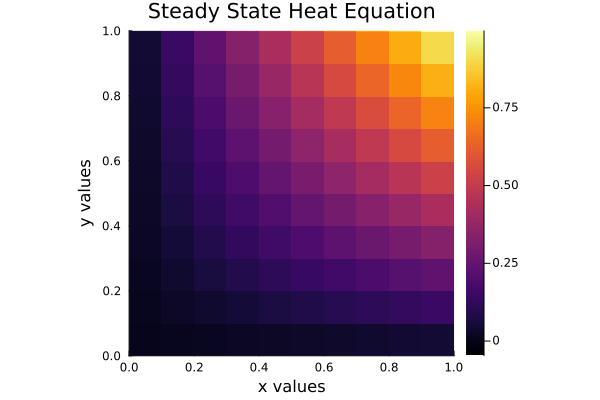

In [10]:
heatmap(
    discrete_x, discrete_y, u_sol,
    xlabel="x values", ylabel="y values", aspect_ratio=:equal,
    title="Steady State Heat Equation", xlims=(0, 1), ylims=(0, 1)
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*